In [835]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import GridSearchCV

Text(0.5, 1.0, 'CryoSat-2 - Brouwer Mean Motion')

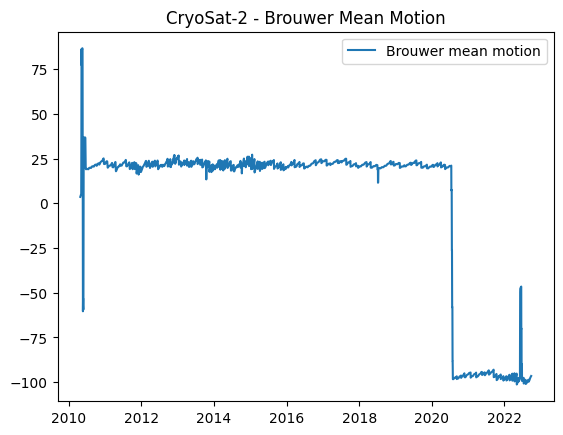

In [836]:
# Location to the file containing the csv file for the data
csv_file_path = "satellite_data/orbital_elements/unpropagated_elements_CryoSat-2.csv"

# Reading the csv data file and creating a dataframe
df = pd.read_csv(csv_file_path, index_col = 0, parse_dates = True)

# Creating a dataframe with only the Brouwer Mean Motion
df_bmm = df[["Brouwer mean motion"]]

# Centering and scaling the data
df_bmm = (df_bmm - df_bmm.mean()) * 1e7

# Plotting the Brouwer Mean Motion
sns.lineplot(data = df_bmm)
plt.title("CryoSat-2 - Brouwer Mean Motion")

In [837]:
start_date = pd.to_datetime("2012")
end_date = pd.to_datetime("2018")

# Filtering maneuvers based on the date range
df_bmm = df_bmm[df_bmm.index >= start_date]
df_bmm = df_bmm[df_bmm.index <= end_date]

df_bmm

,Brouwer mean motion
2012-01-01 07:57:39.564287,18.130458
2012-01-02 15:22:57.895968,18.336931
2012-01-03 17:50:35.417471,18.477485
2012-01-04 18:38:59.315424,18.641606
2012-01-05 19:27:23.188320,18.767743
...,...
2017-12-27 10:34:48.782496,20.175852
2017-12-28 13:02:26.037023,20.252907
2017-12-29 13:50:49.699103,20.324564
2017-12-30 14:39:13.347360,20.394626


In [838]:
NUM_LAG_FEATURES = 3

# Creating features and labels
df_bmm_y = df_bmm.copy()
df_bmm_x = df_bmm.shift(1)

# Renaming the 1st Lag feature
df_bmm_x = df_bmm_x.rename(columns={"Brouwer mean motion": "bmm_lag_1"})

# Adding the rest of the lag features based on the number of lags
for lag in range(2,NUM_LAG_FEATURES + 1):
    df_bmm_x[f"bmm_lag_{lag}"] = df_bmm.shift(lag)

In [839]:
df_bmm_x

,bmm_lag_1,bmm_lag_2,bmm_lag_3
2012-01-01 07:57:39.564287,NaN,NaN,NaN
2012-01-02 15:22:57.895968,18.130458,NaN,NaN
2012-01-03 17:50:35.417471,18.336931,18.130458,NaN
2012-01-04 18:38:59.315424,18.477485,18.336931,18.130458
2012-01-05 19:27:23.188320,18.641606,18.477485,18.336931
...,...,...,...
2017-12-27 10:34:48.782496,20.082347,20.012719,19.958098
2017-12-28 13:02:26.037023,20.175852,20.082347,20.012719
2017-12-29 13:50:49.699103,20.252907,20.175852,20.082347
2017-12-30 14:39:13.347360,20.324564,20.252907,20.175852


In [840]:
df_bmm_y

,Brouwer mean motion
2012-01-01 07:57:39.564287,18.130458
2012-01-02 15:22:57.895968,18.336931
2012-01-03 17:50:35.417471,18.477485
2012-01-04 18:38:59.315424,18.641606
2012-01-05 19:27:23.188320,18.767743
...,...
2017-12-27 10:34:48.782496,20.175852
2017-12-28 13:02:26.037023,20.252907
2017-12-29 13:50:49.699103,20.324564
2017-12-30 14:39:13.347360,20.394626


In [841]:
# Removing rows with NaN values
df_bmm_y = df_bmm_y.iloc[NUM_LAG_FEATURES:]
df_bmm_x = df_bmm_x.iloc[NUM_LAG_FEATURES:]

In [842]:
# Train Test data splitting based on date
SPLIT_DATE = "2015-10-25"
df_bmm_x_train = df_bmm_x[:SPLIT_DATE]
df_bmm_x_test = df_bmm_x[SPLIT_DATE:]
df_bmm_y_train = df_bmm_y[:SPLIT_DATE]
df_bmm_y_test = df_bmm_y[SPLIT_DATE:]

In [843]:
# Getting the training data percentage
train_percentage = df_bmm_y_train.size / (df_bmm_y_train.size + df_bmm_y_test.size)
print(round(train_percentage*100,2))

59.91


In [844]:
# Getting the testing data percentage
test_percentage = df_bmm_y_test.size / (df_bmm_y_train.size + df_bmm_y_test.size)
print(round(test_percentage*100,2))

40.09


In [845]:
# Using grid search to find the best hyperparameters
def grid_search_xgboost(X_train, y_train, cv = 5, verbose = 1):
    param_grid = {
        'n_estimators': [100,1000,1500,2000],
        'max_depth': [5,7,9],
        'learning_rate': [0.01,0.001,0.1],
        'colsample_bytree': [0.5,0.8,1],
        'min_child_weight': [3,5,7]
    }

    xgb_model = XGBRegressor(random_state = 25)

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=cv,
        verbose=verbose,
        n_jobs=1
    )

    grid_search.fit(X_train,y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print("Best Parameters Found:")
    print(best_params)

    return best_model, best_params

best_xgb_model, best_xgb_params = grid_search_xgboost(df_bmm_x_train,df_bmm_y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters Found:
{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100}


In [861]:
# Creating the XGBoost regressor with early stopping to avoid overfitting
xgb_regressor = XGBRegressor(
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.1,
    colsample_bytree = 1,
    min_child_weight = 7,
    subsample = 1,
    eval_metric = 'mae',
    early_stopping_rounds = 10
)

In [862]:
# Fitting the XGBoost model
xgb_regressor.fit(
    df_bmm_x_train,
    df_bmm_y_train,
    eval_set = [(df_bmm_x_train,df_bmm_y_train), (df_bmm_x_test,df_bmm_y_test)],
    verbose = True
)

[0]	validation_0-mae:1.27671	validation_1-mae:1.09456
[1]	validation_0-mae:1.17683	validation_1-mae:1.00927
[2]	validation_0-mae:1.08728	validation_1-mae:0.92755
[3]	validation_0-mae:1.00627	validation_1-mae:0.85790
[4]	validation_0-mae:0.93355	validation_1-mae:0.79448
[5]	validation_0-mae:0.86904	validation_1-mae:0.73551
[6]	validation_0-mae:0.81107	validation_1-mae:0.68194
[7]	validation_0-mae:0.75923	validation_1-mae:0.63568
[8]	validation_0-mae:0.71268	validation_1-mae:0.59225
[9]	validation_0-mae:0.67077	validation_1-mae:0.55461
[10]	validation_0-mae:0.63317	validation_1-mae:0.52052
[11]	validation_0-mae:0.59943	validation_1-mae:0.48980
[12]	validation_0-mae:0.56882	validation_1-mae:0.46209
[13]	validation_0-mae:0.54183	validation_1-mae:0.43725
[14]	validation_0-mae:0.51722	validation_1-mae:0.41461
[15]	validation_0-mae:0.49597	validation_1-mae:0.39449
[16]	validation_0-mae:0.47615	validation_1-mae:0.37487
[17]	validation_0-mae:0.45937	validation_1-mae:0.35921
[18]	validation_0-ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=10, enable_categorical=False,
             eval_metric='mae', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

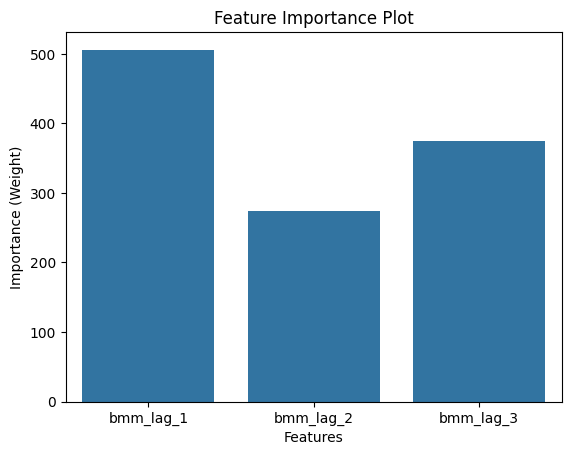

In [863]:
# Generating the feature importance plot
feature_importance = xgb_regressor.get_booster().get_score(importance_type = "weight")
sns.barplot(x = list(feature_importance.keys()), y = list(feature_importance.values()))
plt.xlabel("Features")
plt.ylabel("Importance (Weight)")
plt.title("Feature Importance Plot")
plt.show()

In [864]:
# Defining the format of the maneuver text file
columns_widths = [
    (0,5),      # Satellite Name
    (6,10),     # Begining of manueuver year    
    (11,14),    # Begining of manueuver day       
    (15,17),    # Begining of manueuver hour 
    (18,20),    # Begining of manueuver minute 
    (21,25),    # End of manueuver year 
    (26,29),    # End of manueuver day 
    (30,32),    # End of manueuver hour 
    (33,35),    # End of manueuver minute 
    (36,39),    # Manuever type
    (40,43),    # Manuever parameter type
    (44,45)     # Number of burns
]

# Function to parse each line based on column widths defined
def parse_line(line):
    data = [
        line[start:end].strip()
        for start, end in columns_widths
    ]
    return data

# Function to convert start and end maneuver to datetime
def convert_to_datetime(row):
    start_date = datetime.strptime(f"{row['Start_Year']} {row['Start_Day']} {row['Start_Hour']} {row['Start_Minute']}", "%Y %j %H %M")
    end_date = datetime.strptime(f"{row['End_Year']} {row['End_Day']} {row['End_Hour']} {row['End_Minute']}", "%Y %j %H %M")
    return start_date, end_date

# File path to maneuver file
maneuver_file_path = 'satellite_data/manoeuvres/cs2man.txt'

# Reading the text file into a list of lines
with open(maneuver_file_path, 'r') as txt_file:
    lines = txt_file.readlines()

# Parsing each line into a list of values
parsed_data = [parse_line(line) for line in lines]

# Defining the column names
column_names = [
    'Satellite', 'Start_Year', 'Start_Day', 'Start_Hour', 'Start_Minute',
    'End_Year', 'End_Day', 'End_Hour', 'End_Minute',
    'Maneuver_Type', 'Parameter_Type', 'Number_of_Burns'
]

# Creating a dataframe with the text file data
df = pd.DataFrame(parsed_data, columns = column_names)

# Converting start and end maneuvers to datetime
df['Start_Date'], df['End_Date'] = zip(*df.apply(convert_to_datetime,axis=1))

# Checking the dataframe
print(df.head())

  Satellite Start_Year Start_Day Start_Hour Start_Minute End_Year End_Day  \
0     CRYO2       2010       105         17           47     2010     105   
1     CRYO2       2010       123         17           55     2010     124   
2     CRYO2       2010       124         18           38     2010     124   
3     CRYO2       2010       125         17           44     2010     125   
4     CRYO2       2010       126         18           26     2010     126   

  End_Hour End_Minute Maneuver_Type Parameter_Type Number_of_Burns  \
0       17         48                          006               1   
1       00         35                          006               2   
2       18         48                          006               1   
3       17         59                          006               1   
4       18         51                          006               1   

           Start_Date            End_Date  
0 2010-04-15 17:47:00 2010-04-15 17:48:00  
1 2010-05-03 17:55:00 2010-0

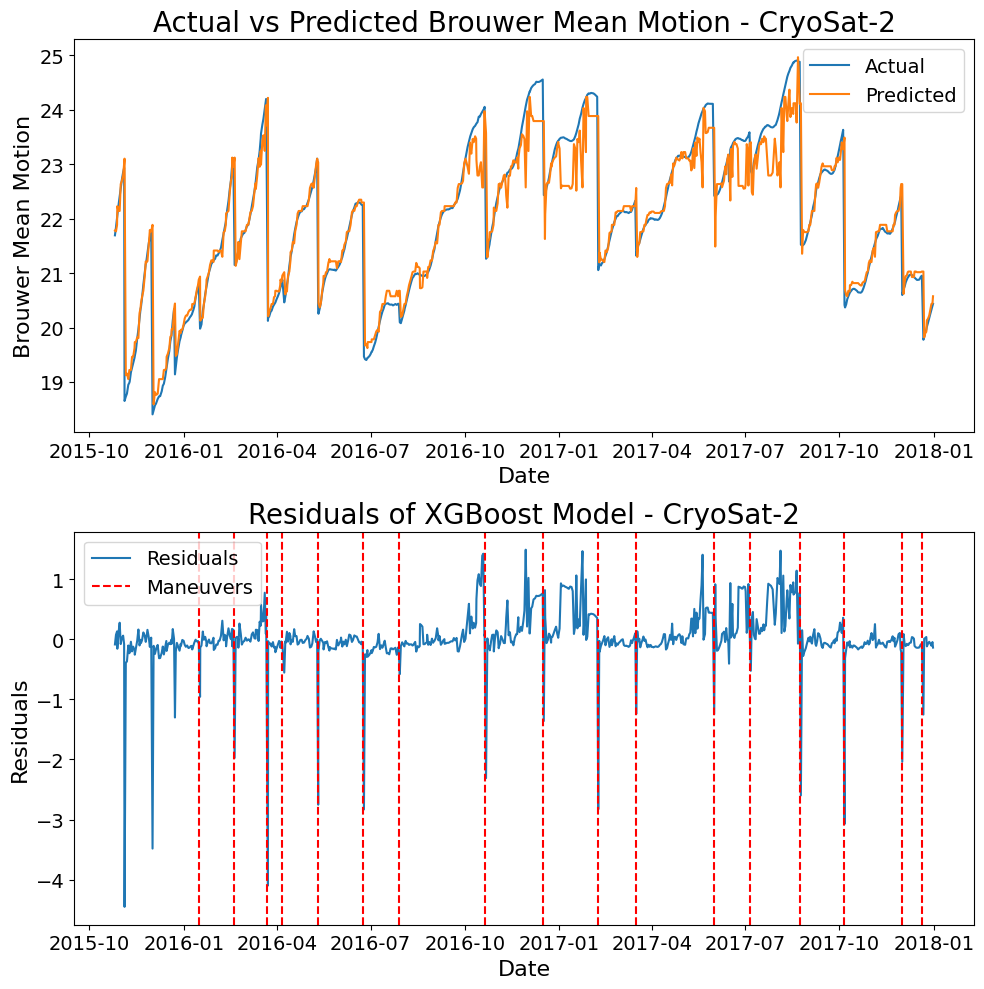

In [878]:
# Generating predictions
predictions = xgb_regressor.predict(df_bmm_x_test)

# Calculating residuals
residuals = df_bmm_y_test['Brouwer mean motion'].to_numpy() - predictions

# Creating a data frame for plotting
df_y_plotting = df_bmm_y_test.copy()
df_y_plotting["residuals"] = residuals
df_y_plotting["predictions"] = predictions

# Creating subplots
fig, axes = plt.subplots(2, 1, figsize = (10,10))

# Plotting actual vs predicted values
sns.lineplot(x = df_bmm_y_test.index, y = df_bmm_y_test["Brouwer mean motion"], label = "Actual", ax = axes[0])
sns.lineplot(x = df_y_plotting.index, y = df_y_plotting["predictions"], label = "Predicted", ax = axes[0])
axes[0].set_title("Actual vs Predicted Brouwer Mean Motion - CryoSat-2", fontsize=20)
axes[0].set_xlabel("Date",fontsize=16)
axes[0].set_ylabel("Brouwer Mean Motion",fontsize=16)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='both',labelsize=14)

# Plotting residuals
sns.lineplot(x = df_y_plotting.index, y = df_y_plotting["residuals"], label = "Residuals", ax = axes[1])
axes[1].set_title("Residuals of XGBoost Model - CryoSat-2", fontsize=20)
axes[1].set_xlabel("Date", fontsize=16)
axes[1].set_ylabel("Residuals", fontsize=16)
axes[1].tick_params(axis='both',labelsize=14)

start_date = pd.to_datetime("2016")
end_date = pd.to_datetime("2018")

# Filtering maneuvers based on the date range
maneuvers_filtered = df[df["Start_Date"] >= start_date]
maneuvers_filtered = maneuvers_filtered[maneuvers_filtered["Start_Date"] <= end_date]

# Marking maneuvers on the residuals plot
maneuver_dates = maneuvers_filtered['Start_Date']
first_label = True
for maneuver_date in maneuver_dates:
    if first_label:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--', label = "Maneuvers")
        first_label = False
    else:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--')     
axes[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

In [866]:
df_y_plotting

,Brouwer mean motion,residuals,predictions
2015-10-25 20:07:44.290847,21.693804,-0.087053,21.780857
2015-10-26 20:56:07.883808,21.842959,0.075074,21.767885
2015-10-27 21:44:31.450848,22.017024,0.130140,21.886885
2015-10-28 04:21:25.731647,22.071061,-0.157983,22.229044
2015-10-29 08:28:16.414463,22.253149,0.111065,22.142084
...,...,...,...
2017-12-27 10:34:48.782496,20.175852,-0.042955,20.218807
2017-12-28 13:02:26.037023,20.252907,-0.071258,20.324165
2017-12-29 13:50:49.699103,20.324564,-0.107401,20.431965
2017-12-30 14:39:13.347360,20.394626,-0.046714,20.441339


In [867]:
# Getting absolute values of the residuals for the anomaly statistic as a series
residuals_series = df_y_plotting["residuals"].abs()
residuals_series = pd.Series(residuals_series, index = df_bmm.index)
residuals_series

2012-01-01 07:57:39.564287         NaN
2012-01-02 15:22:57.895968         NaN
2012-01-03 17:50:35.417471         NaN
2012-01-04 18:38:59.315424         NaN
2012-01-05 19:27:23.188320         NaN
                                ...   
2017-12-27 10:34:48.782496    0.042955
2017-12-28 13:02:26.037023    0.071258
2017-12-29 13:50:49.699103    0.107401
2017-12-30 14:39:13.347360    0.046714
2017-12-31 03:53:01.953888    0.138928
Name: residuals, Length: 1980, dtype: float64

In [868]:
# Sorting the residuals
residuals_series.sort_values
residuals_series

2012-01-01 07:57:39.564287         NaN
2012-01-02 15:22:57.895968         NaN
2012-01-03 17:50:35.417471         NaN
2012-01-04 18:38:59.315424         NaN
2012-01-05 19:27:23.188320         NaN
                                ...   
2017-12-27 10:34:48.782496    0.042955
2017-12-28 13:02:26.037023    0.071258
2017-12-29 13:50:49.699103    0.107401
2017-12-30 14:39:13.347360    0.046714
2017-12-31 03:53:01.953888    0.138928
Name: residuals, Length: 1980, dtype: float64

In [869]:
# Getting the maneuver time stamps into a series in date time format
maneuver_dates_series = pd.Series(pd.to_datetime(df.Start_Date))
maneuver_dates_series

0     2010-04-15 17:47:00
1     2010-05-03 17:55:00
2     2010-05-04 18:38:00
3     2010-05-05 17:44:00
4     2010-05-06 18:26:00
              ...        
163   2022-08-03 17:18:00
164   2022-09-01 17:13:00
165   2022-09-29 16:20:00
166   2022-10-02 19:36:00
167   2022-10-05 19:26:00
Name: Start_Date, Length: 168, dtype: datetime64[ns]

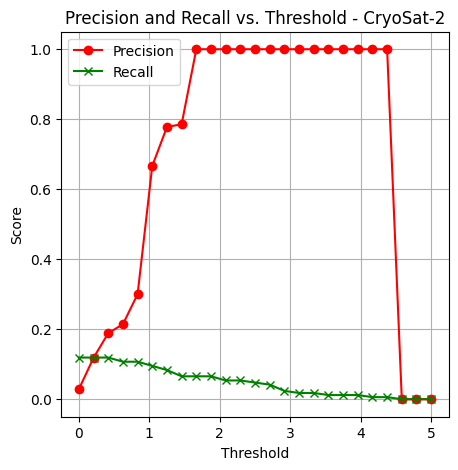

In [870]:
import pandas as pd
import numpy as np

def convert_timestamp_series_to_epoch(series):
    return (
        (series - pd.Timestamp(year=1970, month=1, day=1)) // pd.Timedelta(seconds=1)
    ).values

def compute_simple_matching_precision_recall_for_one_threshold(
    float_matching_max_days,
    float_threshold,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
):
    """
    :param float_matching_max_days:
    :param float_threshold:
    :param pd_series_ground_truth_manoeuvre_timestamps:
    :param pd_series_predictions: The index of this series should be the timestamps of the predictions.
    :return: (precision, recall)

   Computes the precision and recall at one anomaly threshold.

   Does this using an implementation of the framework proposed by Zhao:
   Zhao, L. (2021). Event prediction in the big data era: A systematic survey. ACM Computing Surveys (CSUR), 54(5), 1-37.
   https://doi.org/10.1145/3450287

   The method matches each manoeuvre prediction with the closest ground-truth manoeuvre, if it is within a time window.

   Predictions with a match are then true positives and those without a match are false positives. Ground-truth manoeuvres
   with no matching prediction are counted as false negatives.
   """

    matching_max_distance_seconds = pd.Timedelta(days=float_matching_max_days).total_seconds()

    dict_predictions_to_ground_truth = {}
    dict_ground_truth_to_predictions = {}

    np_manoeuvre_timestamps_seconds = convert_timestamp_series_to_epoch(pd_series_ground_truth_manoeuvre_timestamps)
    np_pred_time_stamps_seconds = convert_timestamp_series_to_epoch(pd_series_predictions.index)
    np_predictions = pd_series_predictions.to_numpy()

    for i in range(np_predictions.shape[0]):
        if np_predictions[i] >= float_threshold:
            left_index = np.searchsorted(
                np_manoeuvre_timestamps_seconds, np_pred_time_stamps_seconds[i]
            )

            if left_index != 0:
                left_index -= 1

            index_of_closest = left_index

            if (left_index < pd_series_ground_truth_manoeuvre_timestamps.shape[0] - 1) and (
                abs(np_manoeuvre_timestamps_seconds[left_index] - np_pred_time_stamps_seconds[i])
                > abs(np_manoeuvre_timestamps_seconds[left_index + 1] - np_pred_time_stamps_seconds[i])
            ):
                index_of_closest = left_index + 1

            diff = abs(np_manoeuvre_timestamps_seconds[index_of_closest] - np_pred_time_stamps_seconds[i])

            if diff < matching_max_distance_seconds:
                dict_predictions_to_ground_truth[i] = (
                    index_of_closest,
                    diff,
                )
                if index_of_closest in dict_ground_truth_to_predictions:
                    dict_ground_truth_to_predictions[index_of_closest].append(i)
                else:
                    dict_ground_truth_to_predictions[index_of_closest] = [i]

    np_positive_prediction_indices = np.argwhere(np_predictions >= float_threshold)[:, 0]
    list_false_positives = [
        pred_ind for pred_ind in np_positive_prediction_indices if pred_ind not in dict_predictions_to_ground_truth.keys()
    ]
    list_false_negatives = [
        true_ind for true_ind in np.arange(0, len(pd_series_ground_truth_manoeuvre_timestamps))
        if true_ind not in dict_ground_truth_to_predictions.keys()
    ]

    precision = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_positives)) if (len(dict_ground_truth_to_predictions) + len(list_false_positives)) > 0 else 0
    recall = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) if (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) > 0 else 0

    total_negatives = len(np_predictions) - len(pd_series_ground_truth_manoeuvre_timestamps)
    fpr = len(list_false_positives)/total_negatives

    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall)/(precision + recall)

    return (precision, recall, fpr, f1_score)

# Create plot with precision and recall values for different thresholds
def plot_precision_recall_against_threshold_curve(threshold_range, precisions, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(threshold_range, precisions, marker='o', label='Precision', color='red')
    plt.plot(threshold_range, recalls, marker='x', label='Recall', color='green')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Threshold - CryoSat-2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculating precision and recall for multiple thresholds
def compute_precision_recall_fpr_for_multiple_thresholds(
    float_matching_max_days,
    threshold_range,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
):
    precisions = []
    recalls = []
    fprs = []
    f1_scores = []

    for threshold in threshold_range:
        precision, recall, fpr, f1_score = compute_simple_matching_precision_recall_for_one_threshold(
            float_matching_max_days,
            threshold,
            pd_series_ground_truth_manoeuvre_timestamps,
            pd_series_predictions,
        )
        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        f1_scores.append(f1_score)

    return precisions, recalls, fprs, f1_scores

if __name__ == "__main__":

    float_matching_max_days = 3
    threshold_range = np.linspace(0,5,25)

    precisions, recalls, fprs, f1_scores = compute_precision_recall_fpr_for_multiple_thresholds(
    float_matching_max_days,
    threshold_range,
    maneuver_dates_series,
    residuals_series,
    )

    plot_precision_recall_against_threshold_curve(threshold_range,precisions,recalls)

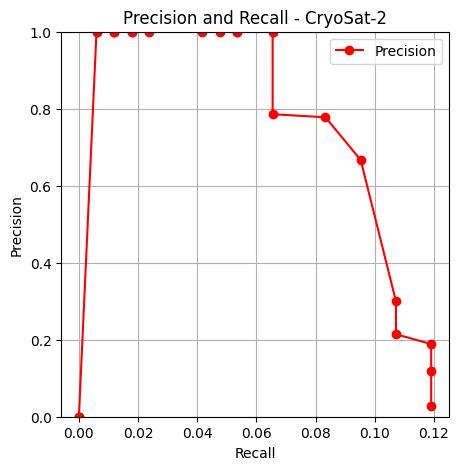

In [871]:
# Create plot with precision and recall
def plot_precision_recall_curve(precisions, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(recalls, precisions, marker = 'o', label='Precision', color='red')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision and Recall - CryoSat-2')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall_curve(precisions, recalls)

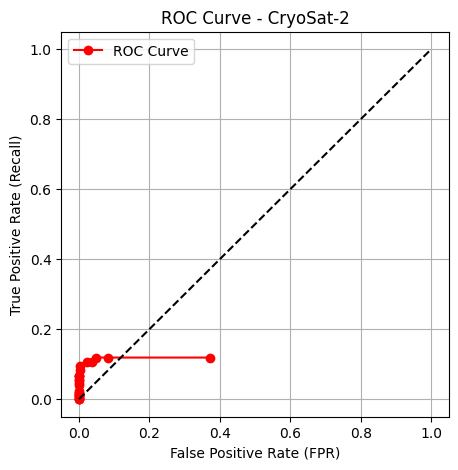

In [872]:
# Create roc plot
def plot_roc_curve(fprs, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(fprs, recalls, marker = 'o', label = 'ROC Curve', color='red')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve - CryoSat-2')
    plt.plot([0,1], [0,1], 'k--')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curve(fprs, recalls)

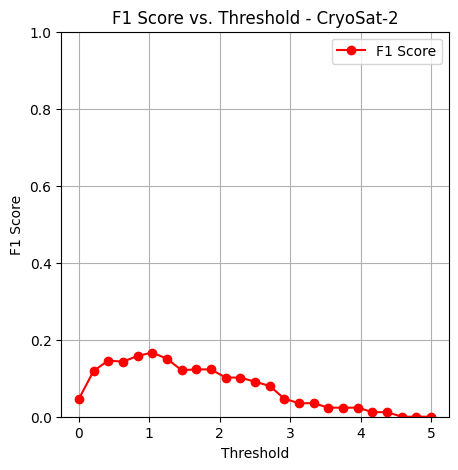

In [873]:
# Create f1_score vs threshold
def plot_f1_score_curve(threshold_range, f1_scores):
    plt.figure(figsize=(5,5))
    plt.plot(threshold_range, f1_scores, marker = 'o', label = 'F1 Score', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold - CryoSat-2')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_f1_score_curve(threshold_range, f1_scores)

In [874]:
# Finding the max f1 score and the relevant threshold
max_index = np.argmax(f1_scores)
max_val = f1_scores[max_index]
max_val_threshold = threshold_range[max_index]

print(max_val)
print(max_val_threshold)

0.16666666666666666
1.0416666666666667


In [875]:
# Finding the precision and recall for max f1 score
precision, recall, fpr, f1_score = compute_simple_matching_precision_recall_for_one_threshold(
            float_matching_max_days,
            max_val_threshold,
            maneuver_dates_series,
            residuals_series,
        )

print(precision)
print(recall)

0.6666666666666666
0.09523809523809523
